In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import imutils
import dlib
import cv2

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb



**Getting the datasets from our Google Drive Folder. **

In [ ]:
!wget /content/drive/MyDrive/404botsdatasets

/content/drive/MyDrive/404botsdatasets: Scheme missing.


In [ ]:
data = np.load('/content/drive/MyDrive/404botsdatasets/404botsdataset.npz', allow_pickle=True)
X = data['arr_0'] #closed eyes
Y = data['arr_1'] #opened eyes

X = list(X)
Y = list(Y)
print("The number of closed eyes images :", len(X))
print("The number of closed eyes images :", len(Y))

The number of closed eyes images : 1452
The number of closed eyes images : 1452


In [ ]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print("The images size & dimensions :", X[0].shape)

1452
The images size & dimensions : (32, 32, 3)


In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [ ]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


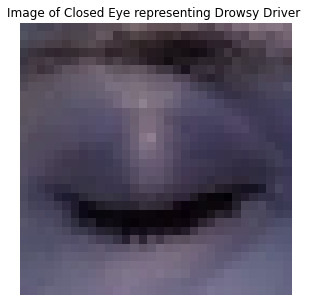

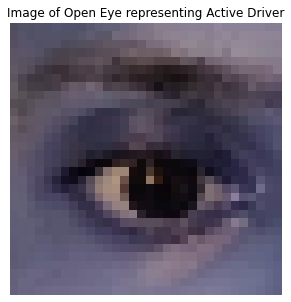

In [ ]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Drowsy Driver ')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Active Driver')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


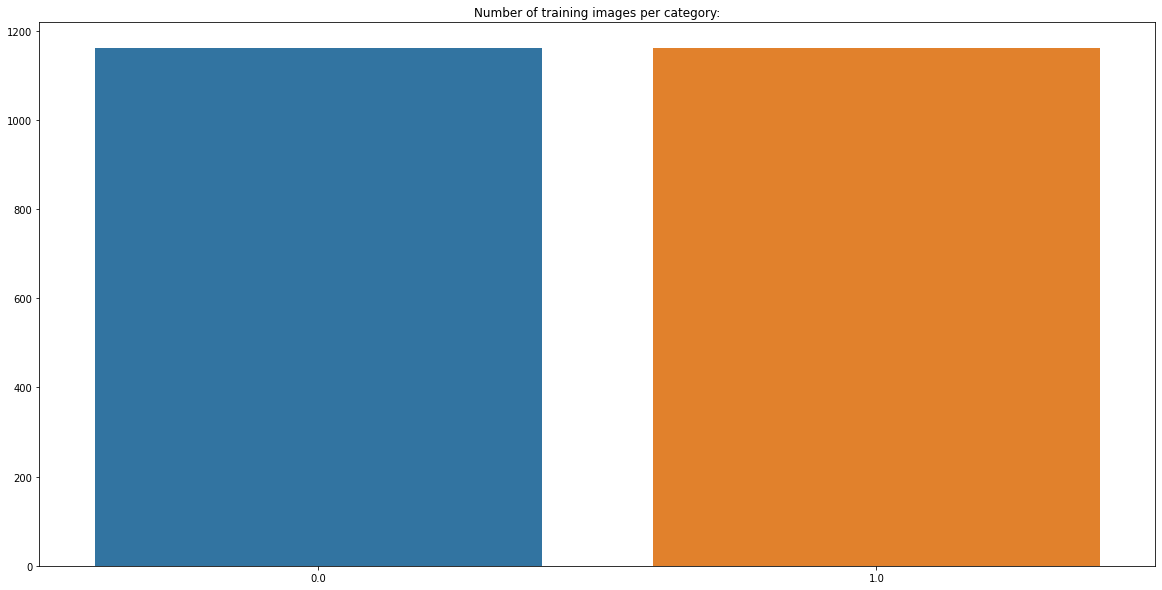

In [ ]:
unique_train, count = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_train, count).set_title("Number of training images per category:")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


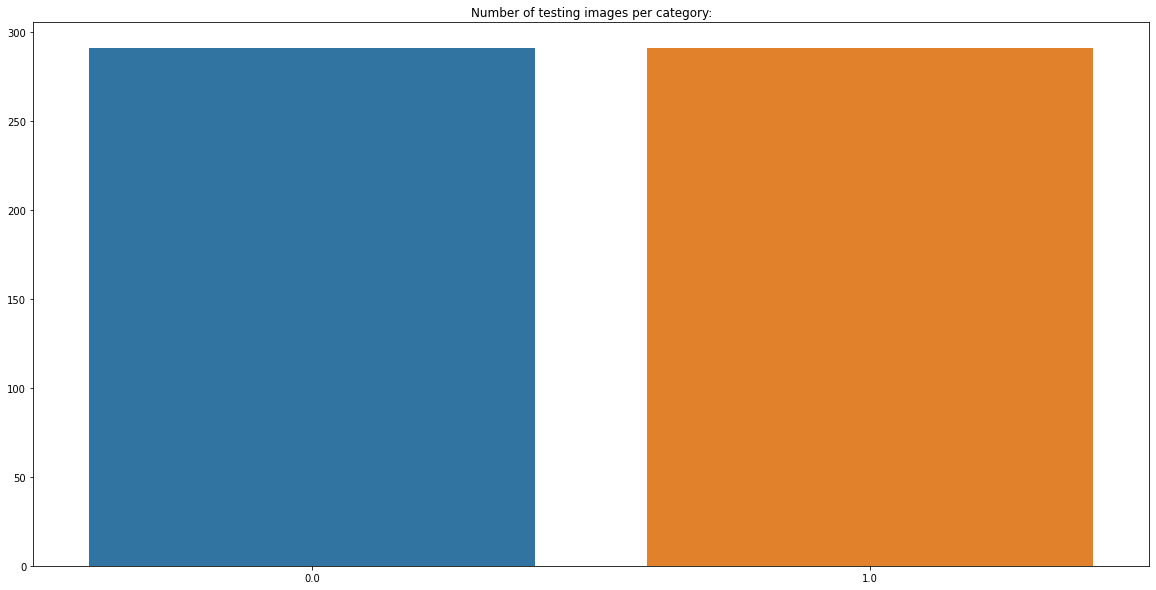

In [ ]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_test, count_test).set_title("Number of testing images per category:")
plt.show()

MODEL ARCHITECTURE

In [ ]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [ ]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=500, validation_data=(X_test, Y_test))

Epoch 1/500
10/10 [==============================] - 7s 529ms/step - loss: 1.2911 - accuracy: 0.5263 - val_loss: 0.6916 - val_accuracy: 0.5189
Epoch 2/500
10/10 [==============================] - 5s 505ms/step - loss: 1.2747 - accuracy: 0.5357 - val_loss: 0.6801 - val_accuracy: 0.5361
Epoch 3/500
10/10 [==============================] - 5s 505ms/step - loss: 1.1178 - accuracy: 0.5530 - val_loss: 0.6721 - val_accuracy: 0.5636
Epoch 4/500
10/10 [==============================] - 5s 499ms/step - loss: 1.0836 - accuracy: 0.5581 - val_loss: 0.6622 - val_accuracy: 0.5945
Epoch 5/500
10/10 [==============================] - 5s 495ms/step - loss: 0.9809 - accuracy: 0.5960 - val_loss: 0.6547 - val_accuracy: 0.6701
Epoch 6/500
10/10 [==============================] - 5s 497ms/step - loss: 0.8958 - accuracy: 0.6055 - val_loss: 0.6497 - val_accuracy: 0.7010
Epoch 7/500
10/10 [==============================] - 5s 542ms/step - loss: 0.9585 - accuracy: 0.6029 - val_loss: 0.6434 - val_accuracy: 0.7079

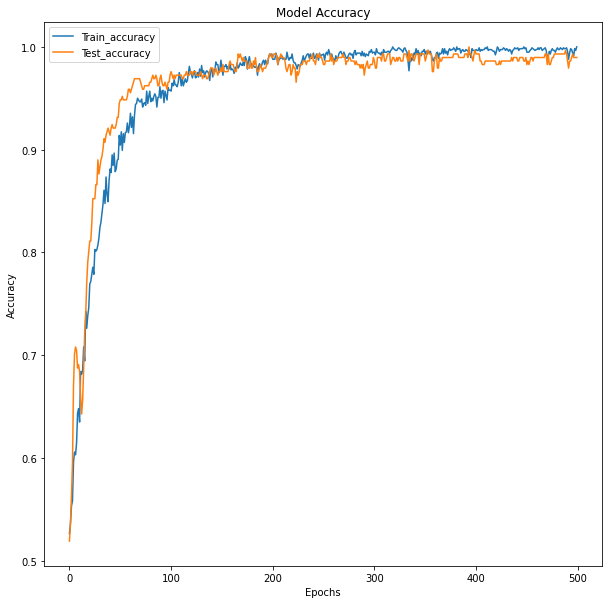

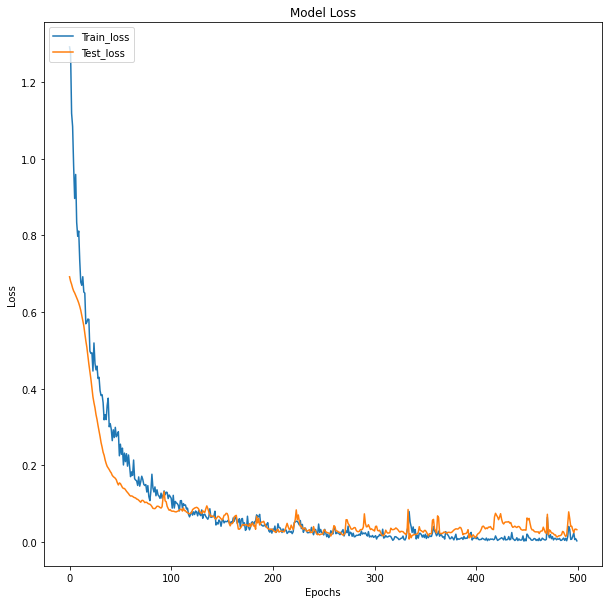

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 1s 45ms/step - loss: 0.0321 - accuracy: 0.9897
Test Set Accuracy: 0.9896907210350037
Test Set Loss: 0.03214192017912865


In [ ]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       136
           1       0.99      0.99      0.99       155

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



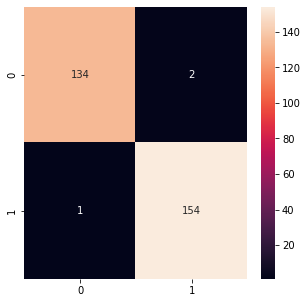

In [ ]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [ ]:
#model.save('Driver_Drowsiness_Detection.h5')
model.save('/content/drive/MyDrive/404botsdatasets/Driver_Drowsiness_Detection.h5')

In [ ]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('/content/drive/MyDrive/404botsdatasets/closed_eye.jpg')
img_closed2 = cv2.imread('/content/drive/MyDrive/404botsdatasets/closed_eye2.jpg')
img_open1 = cv2.imread('/content/drive/MyDrive/404botsdatasets/open_eye.jpg')
img_open2 = cv2.imread('/content/drive/MyDrive/404botsdatasets/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [ ]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

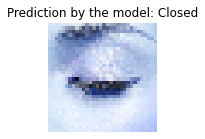

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

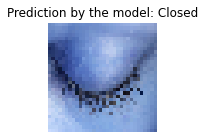

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

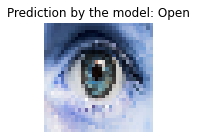

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

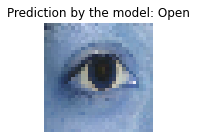

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

In [ ]:
def full_face_detection_pipeline(input_image_path):
    face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/404botsdatasets/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/404botsdatasets/haarcascade_eye.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/404botsdatasets/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
#             cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Drowsy!!', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Active State', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = '/content/drive/MyDrive/404botsdatasets/test_image_prediction.jpg'
    cv2.imwrite(output_path, test_image) 
    return output_path

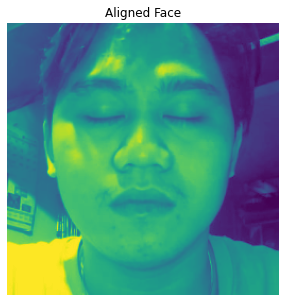

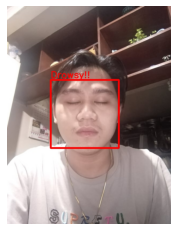

In [ ]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('/content/drive/MyDrive/404botsdatasets/poy1.jpg'))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

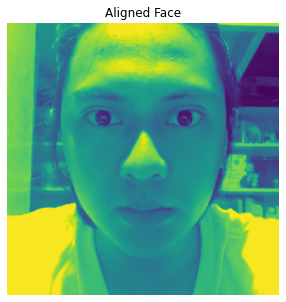

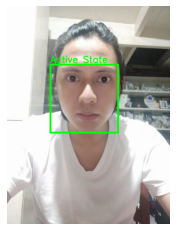

In [ ]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('/content/drive/MyDrive/404botsdatasets/abais2.jpg'))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

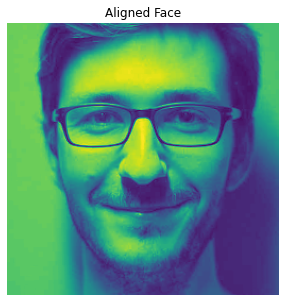

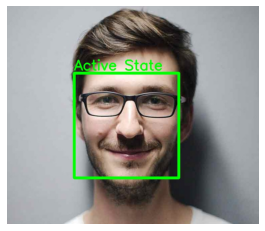

In [ ]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('/content/drive/MyDrive/404botsdatasets/bwg.jpg'))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

In [ ]:
figure = plt.figure(figsize=(5, 5))
predicted_image = cv2.imread(full_face_detection_pipeline('/content/drive/MyDrive/404botsdatasets/ee4.png'))
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

AttributeError: ignored

<Figure size 360x360 with 0 Axes>